In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
from MultiStepLSTM import WirelineLog, MultiStepLTSM
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler
from keras.models import load_model, model_from_json
from scipy.stats import multivariate_normal


Using TensorFlow backend.


# Steps to Training

0) Split data into 4 subsets

    a) Train, Test, Validation1, Validation2

1) Train Model on non-ccl kicks (data inbetween collars) scaled to mean=0, variance=1

2) Calcualte anomalies (p-value) on actual ccl data

    a) collars will show up as anomalies,but severity of anoamly is what matters

# Split data into 4 subsets

In [3]:
from sklearn.model_selection import train_test_split

ccl_log = WirelineLog()
ccl_log.read("/home/duys/Downloads/anadarko.las")
ccl = ccl_log.df['CCL'].dropna().values

In [4]:
non_anomaly_dset = []

for i in range(int(len(ccl)/2)):
    if ccl[i] > 0.5 or ccl[i] < -0.5:
        continue
    non_anomaly_dset.append(ccl[i])
non_anomaly_dset = np.array(non_anomaly_dset)
non_anomaly_dset.shape

(6931,)

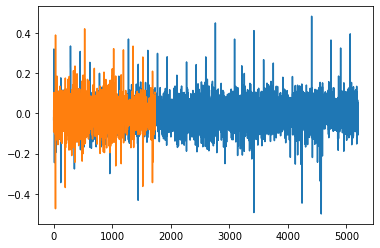

In [5]:
train, validation1 = train_test_split(non_anomaly_dset, shuffle=False, test_size=0.25)
plt.plot(train)
plt.plot(validation1)

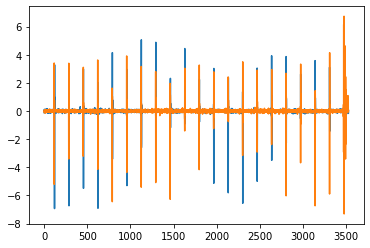

In [6]:
other_half = ccl[int(len(ccl)/2):]
test, validation2 = train_test_split(other_half, test_size=0.5, shuffle=False)
plt.plot(test)
plt.plot(validation2)

In [7]:
ccl_data = {
    "train" : train, #non-anomalous data
    "validation_1" : validation1, # also non-anomalous data
    "test": test, # anomalous data mix
    "validation_2": validation2
}

# Build Model with the split data

In [8]:
model2 = MultiStepLTSM(batch_size=250, look_back=249, epochs=5, hidden_n=100, look_ahead=1, dropout=0.5)
model2.insert_data(ccl_data)
model2.build_model(iterations=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (250, 249, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (250, 249, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (250, 249, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (250, 249, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (250, 100)                80400     
_________________________________________________________________
dense_1 (Dense)      

In [9]:
model2.train_model()

Instructions for updating:
Use tf.cast instead.
Train on 4750 samples, validate on 1250 samples
Epoch 1/5
4750/4750 [==============================] - 11s 2ms/step - loss: 0.0046 - mean_absolute_error: 0.0508 - val_loss: 0.0052 - val_mean_absolute_error: 0.0549
resetting states
Epoch 2/5
4750/4750 [==============================] - 9s 2ms/step - loss: 0.0045 - mean_absolute_error: 0.0500 - val_loss: 0.0052 - val_mean_absolute_error: 0.0548
resetting states
Epoch 3/5
4750/4750 [==============================] - 9s 2ms/step - loss: 0.0045 - mean_absolute_error: 0.0499 - val_loss: 0.0052 - val_mean_absolute_error: 0.0546
resetting states
Epoch 4/5
4750/4750 [==============================] - 9s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0498 - val_loss: 0.0052 - val_mean_absolute_error: 0.0542
resetting states
Epoch 5/5
4750/4750 [==============================] - 9s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0496 - val_loss: 0.0051 - val_mean_absolute_error: 0.0537
resetting 

In [10]:
x_train, y_train = model2.data['train']['x'], model2.data['train']['y']
x_test, y_test = model2.data['test']['x'], model2.data['test']['y']
valid2_x, valid2_y = model2.data['validation_2']['x'], model2.data['validation_2']['y']
batch_size = model2.batch_size

train_loss = model2.evaluate(x_train, y_train[:,0], batch_size=batch_size)
test_loss = model2.evaluate(x_test, y_test[:,0], batch_size=batch_size)
validation2_loss = model2.evaluate(valid2_x, valid2_y[:,0], batch_size=batch_size)
print(train_loss)
print(test_loss)
print(validation2_loss)

3250/3250 [==============================] - 2s 748us/step
[0.004371326686324258, 0.049307851022795626]
[0.1798884507555228, 0.0976898458141547]
[0.2416528812967814, 0.11174125510912675]


In [11]:
model2.predict_on(model2.data['test']['x'], name='test', inverse_transform=False)

(3250, 1) (3250,) 1


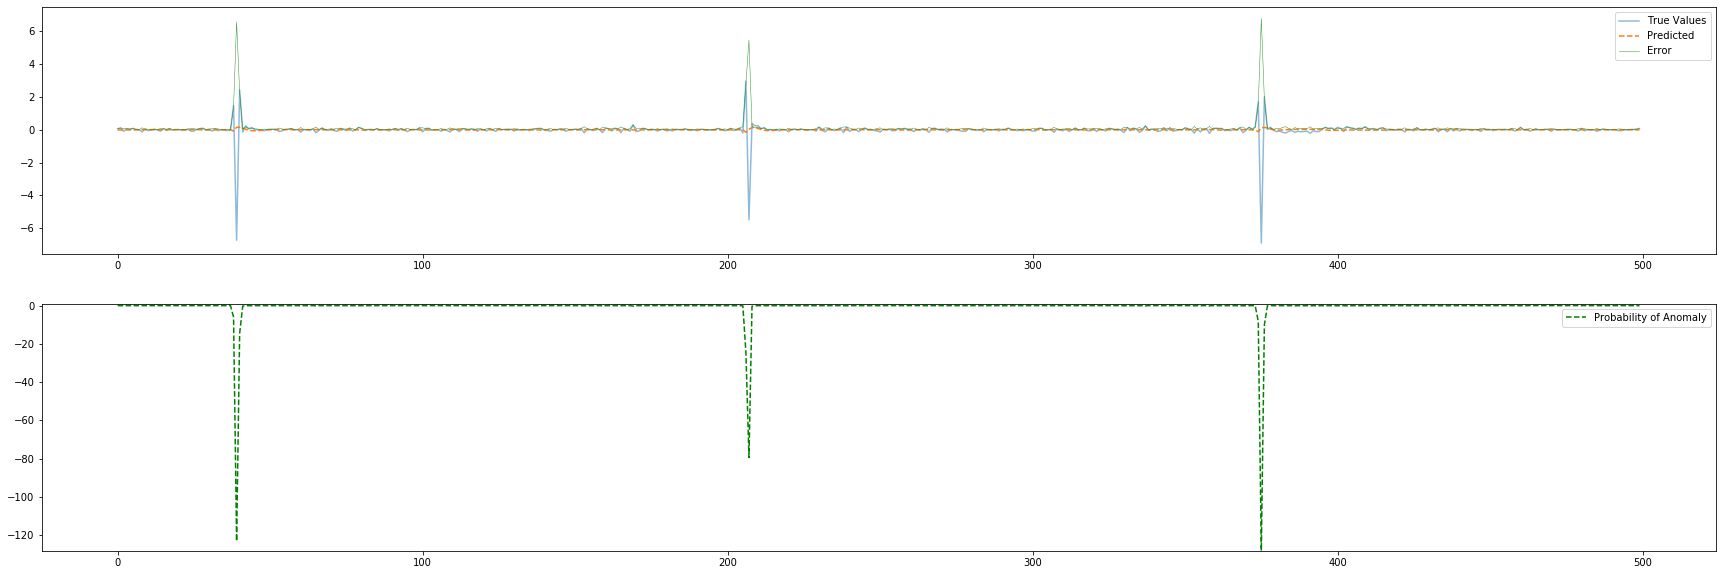

In [13]:
model2.plot_error(true_name='test', pred_name='test', i1=None, i2=500)


# Test trained model on new ccl data from another log

In [14]:
# model2.predict_on(model2.data['test']['x'], name='test', inverse_transform=False)
#model2 = load_model('ccl_test.keras-model', custom_objects={'MultiStepLTSM': MultiStepLTSM})
anadarko_log = WirelineLog()
anadarko_log.read("/home/duys/Downloads/anadarko2.las")
new_ccl = scale(anadarko_log.df['CCL'].dropna().values)

In [15]:
model2.insert_data({'new_ccl' : new_ccl})

In [16]:
model2.predict_on(model2.data['new_ccl']['x'], name='external_data', inverse_transform=False)

(3500, 1) (3500,) 1


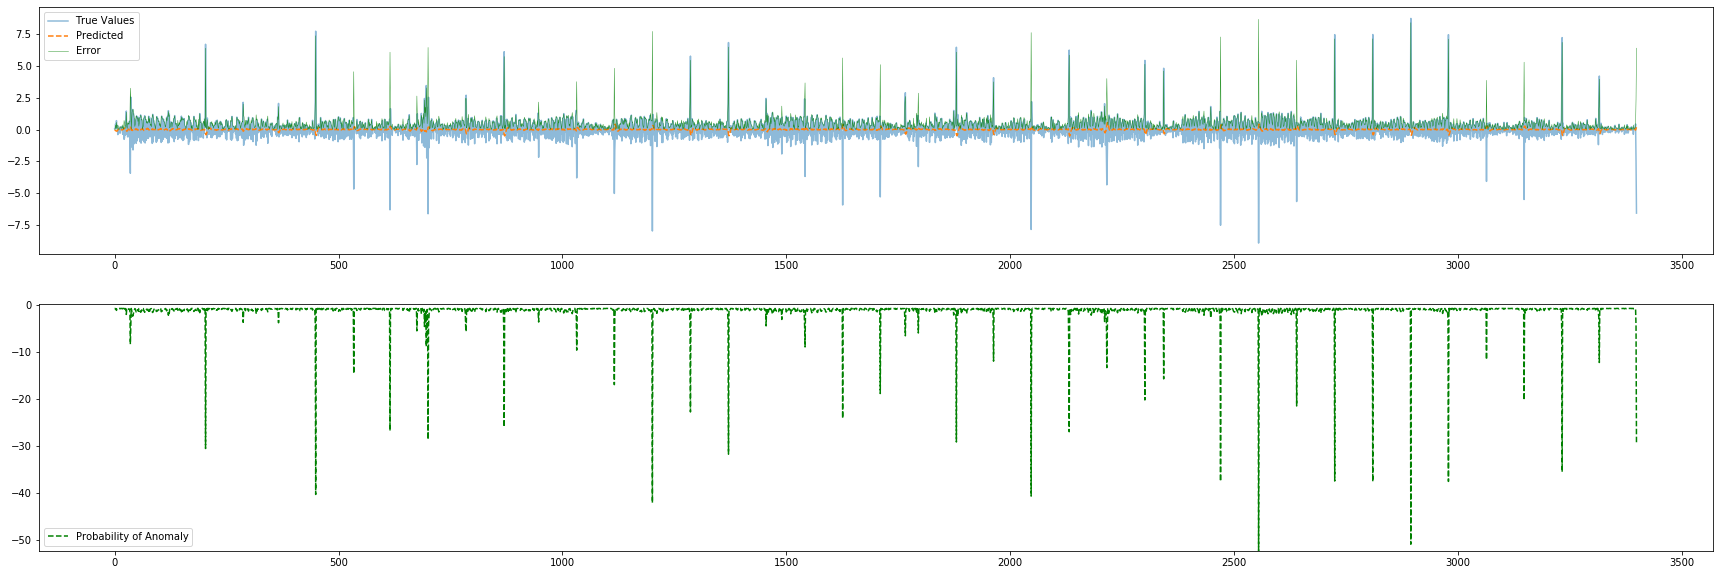

In [17]:
model2.plot_error(true_name="new_ccl", pred_name="external_data", i1=100, i2=None)

# Test trained model on a second different ccl data from different log

In [18]:
stage_log = WirelineLog()
stage_log.read("/home/duys/Downloads/ccl_data/stage2b-pass4.las")
stage_ccl = scale(stage_log.df['CCL'].dropna().values)
stage_ccl.shape

(81410,)

In [19]:
# model2 = load_model('ccl-model.keras', custom_objects={"MultiStepLTSM" : MultiStepLTSM})

In [20]:
model2.insert_data({'stage_ccl' : stage_ccl})

In [21]:
model2.predict_on(model2.data['stage_ccl']['x'], name='external_data2', inverse_transform=False)

(81000, 1) (81000,) 1


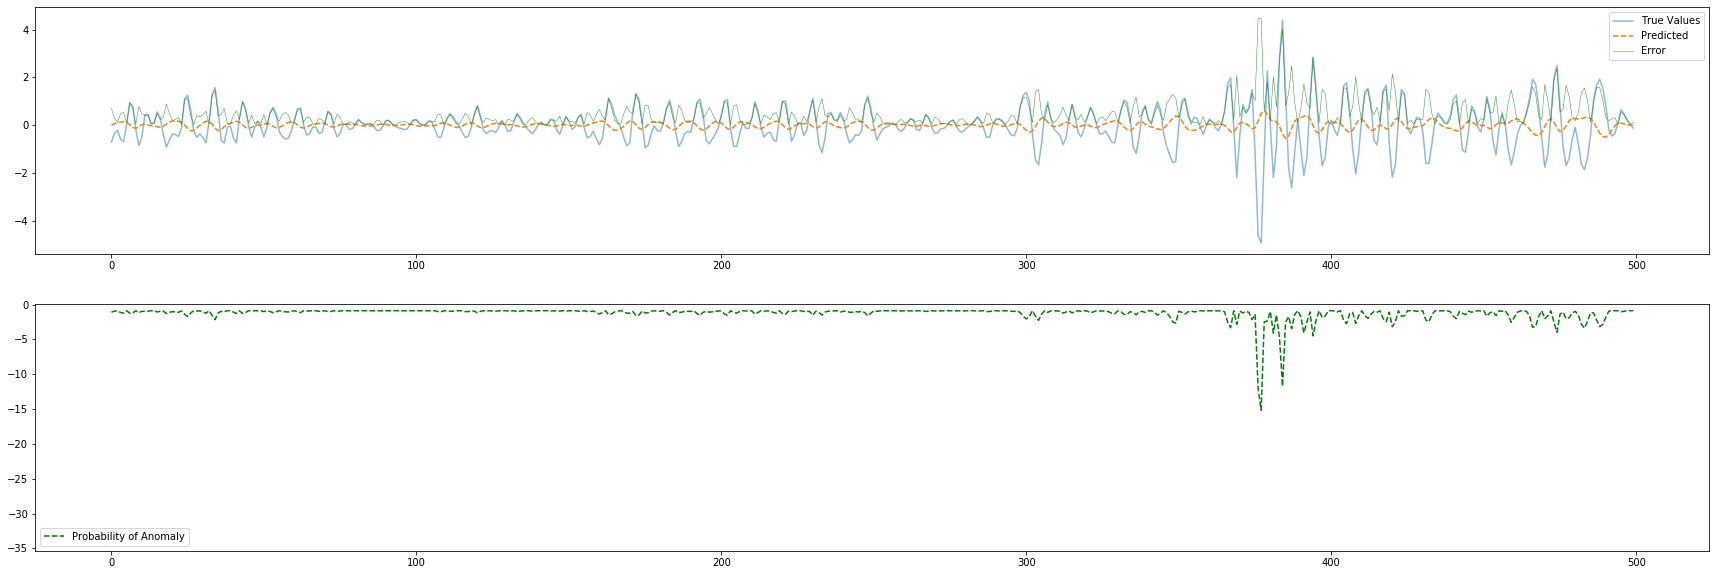

In [22]:
model2.plot_error(true_name='stage_ccl',pred_name='external_data2', i1=75500, i2=75000)

In [24]:
model2.save_all('ccl-model2.keras')


# Test trained model on a log signature used in Downhole Emulator

In [25]:
m = load_model('ccl-model2.keras', custom_objects={"MultiStepLTSM" : MultiStepLTSM})
m.load_all('ccl-model2.keras.h5')
print(m.batch_size)

250


In [26]:
m.look_back

249

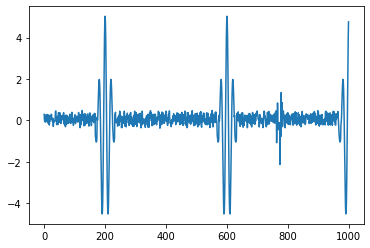

In [27]:
pseudo_ccl = scale(np.load('pseudo_ccl.npy'))
pseudo_ccl.shape
plt.plot(pseudo_ccl[:1000])

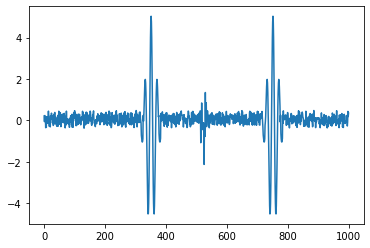

In [28]:
m.insert_data({"pseudo_ccl" : pseudo_ccl})
plt.plot(m.data['pseudo_ccl']['y'][:1000,0])

In [29]:
m.predict_on(m.data['pseudo_ccl']['x'], name='pseudo_ccl', inverse_transform=False)


(7750, 1) (7750,) 1


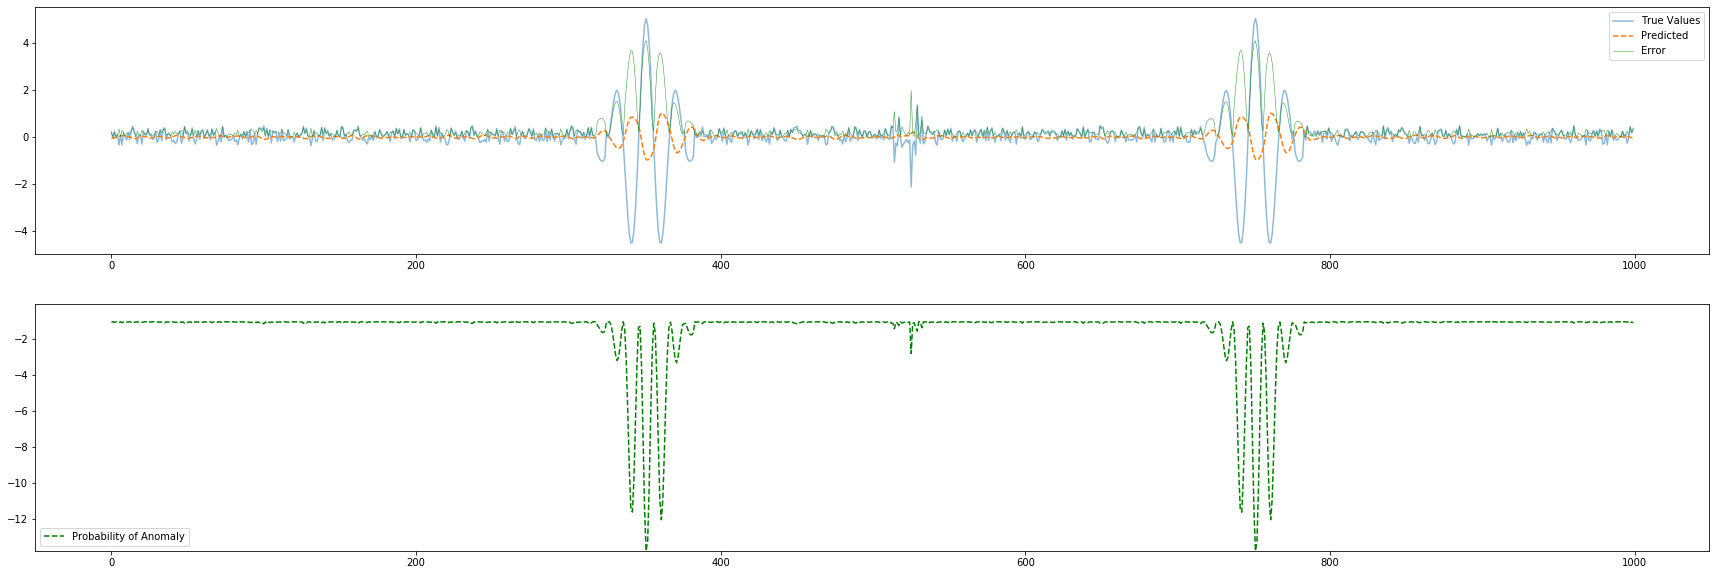

In [30]:
m.plot_error(true_name='pseudo_ccl',pred_name='pseudo_ccl', i1=None, i2=1000)

In [31]:
m.data.keys()

dict_keys(['new_ccl', 'stage_ccl', 'test', 'train', 'validation_1', 'validation_2', 'pseudo_ccl'])

In [32]:
m.predictions.keys()

dict_keys(['external_data', 'external_data2', 'test', 'pseudo_ccl'])

# How to implement model into real-time plotting

Can only predict n_batch values at a time using a batch of n values at look_back time steps back to give a tensor shape of (n_batch, look_back, look_ahead)
In order to use on real-time plot - needs to wait until we gather look_back+n_batch+look_ahead values then preprocess data to obtain n_batch sized 
batch.

model.predict is then run on samples to output n_batch sized predictions. As values come in, calculate p-value of each
real value compared to the predicted value, and plot probablity point. Do this until prediction batch runs out, and 
rerun model predict on new n_batch sized values that was used to create p-values.
 

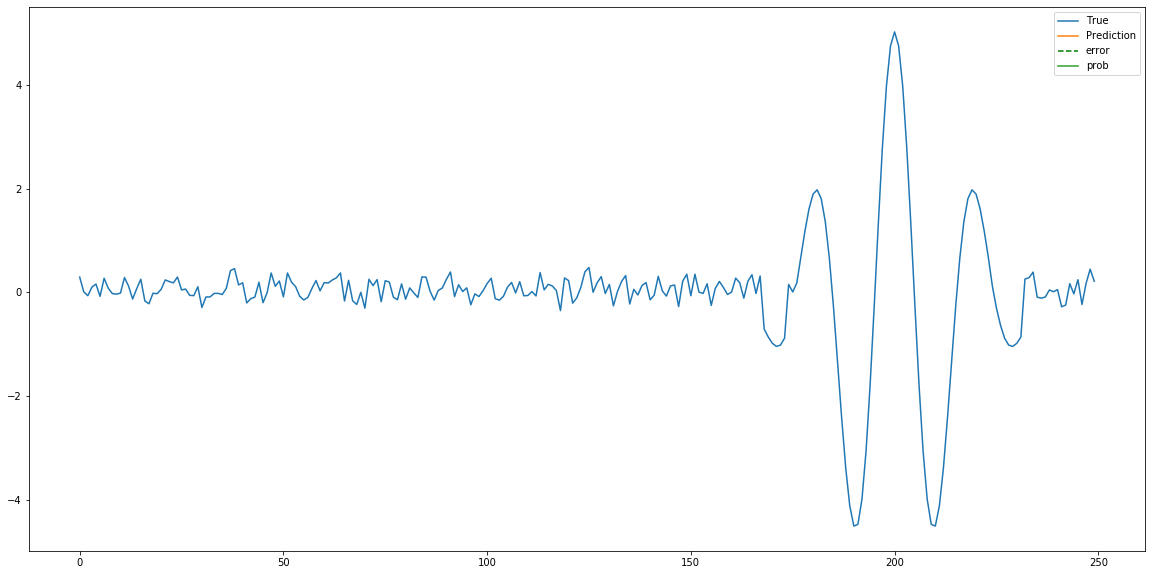

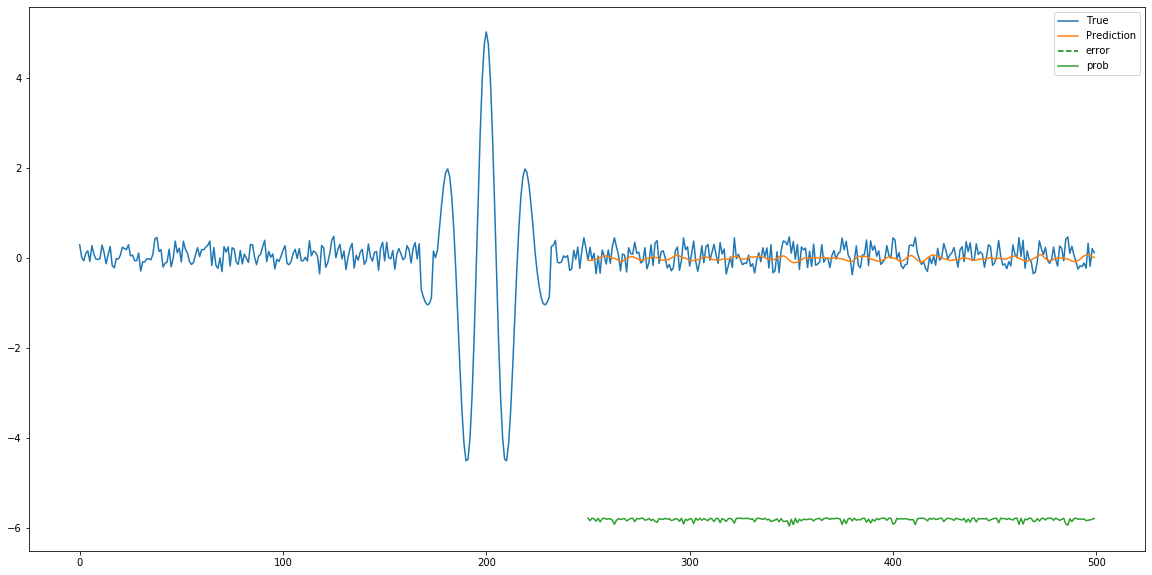

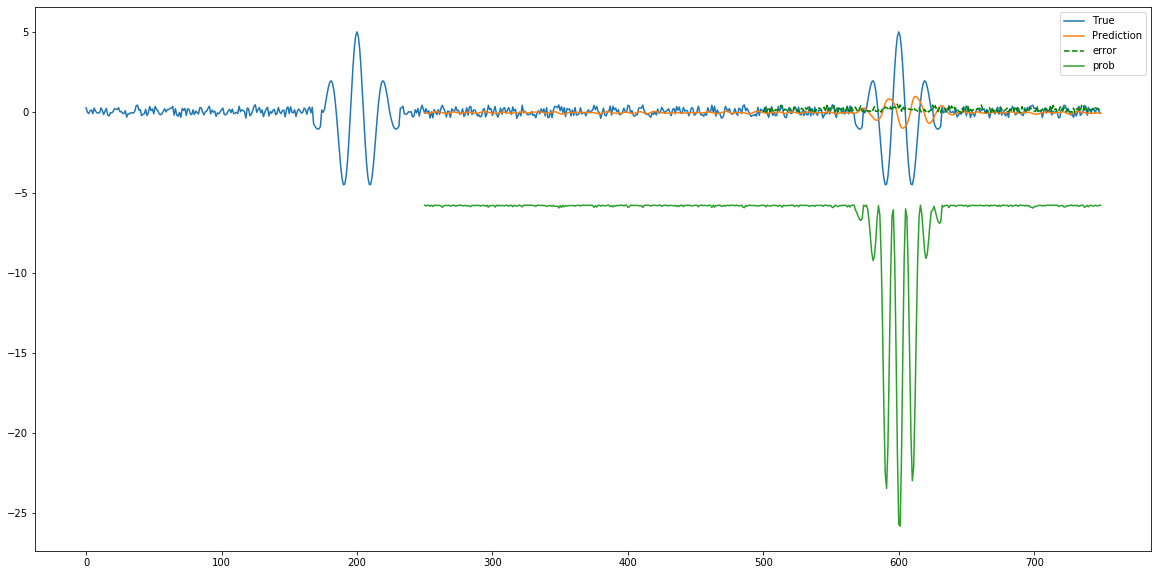

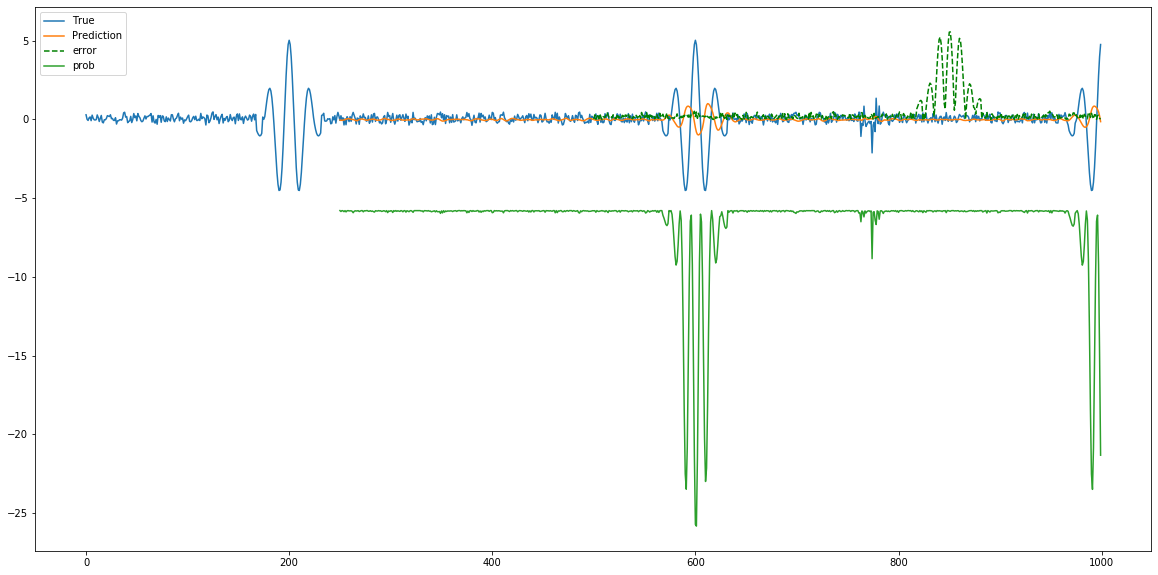

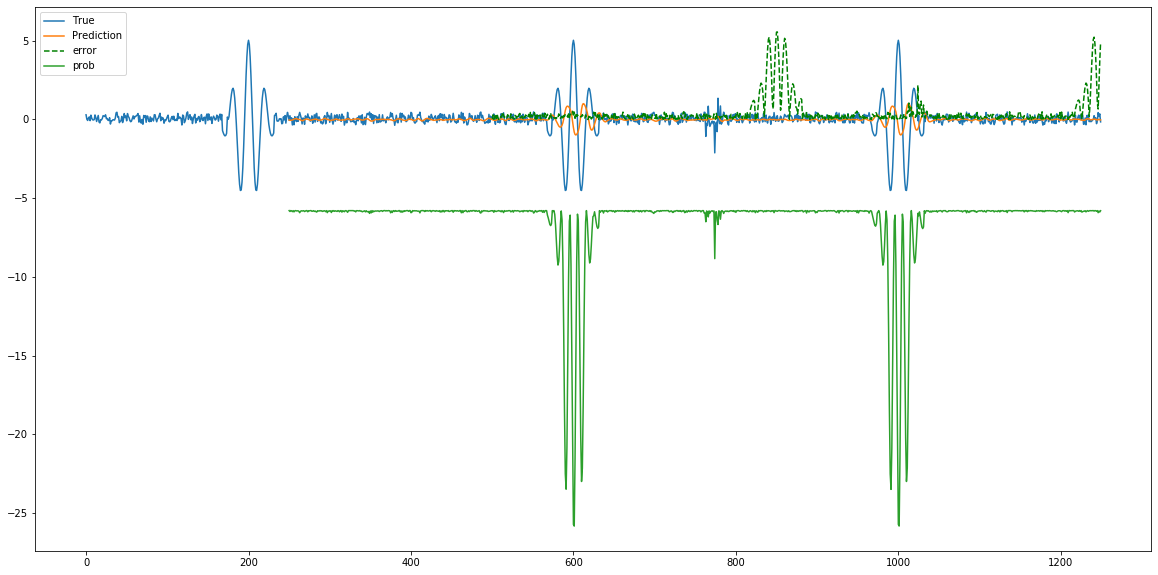

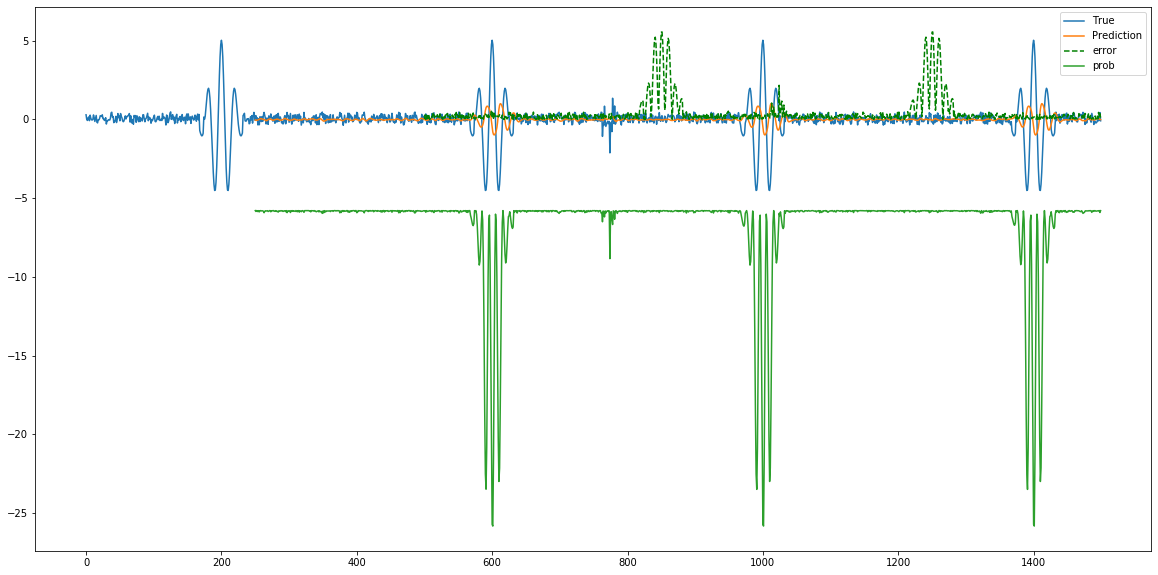

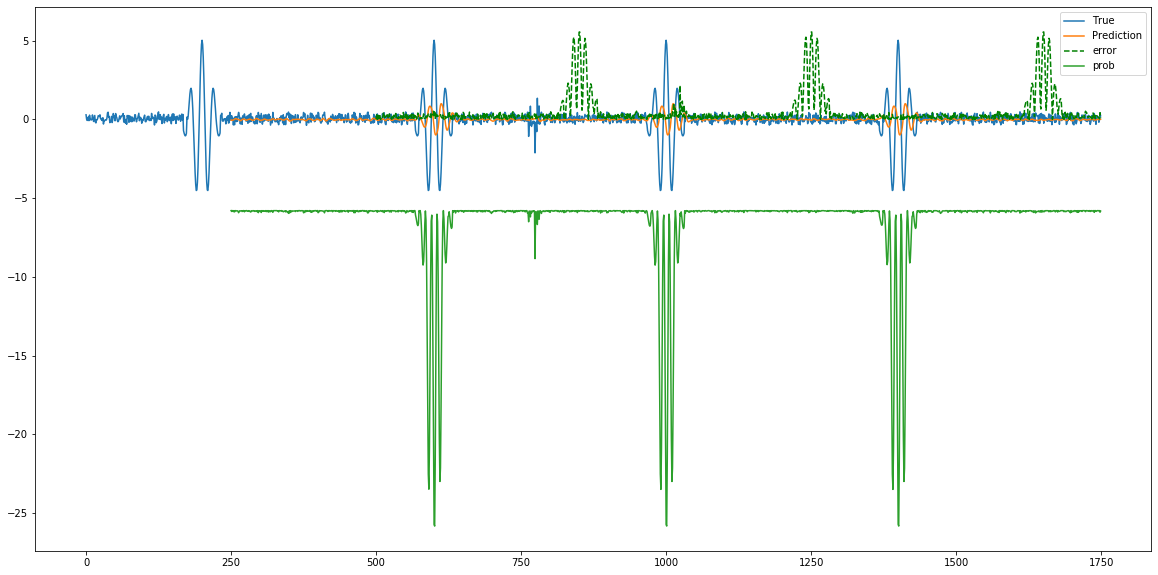

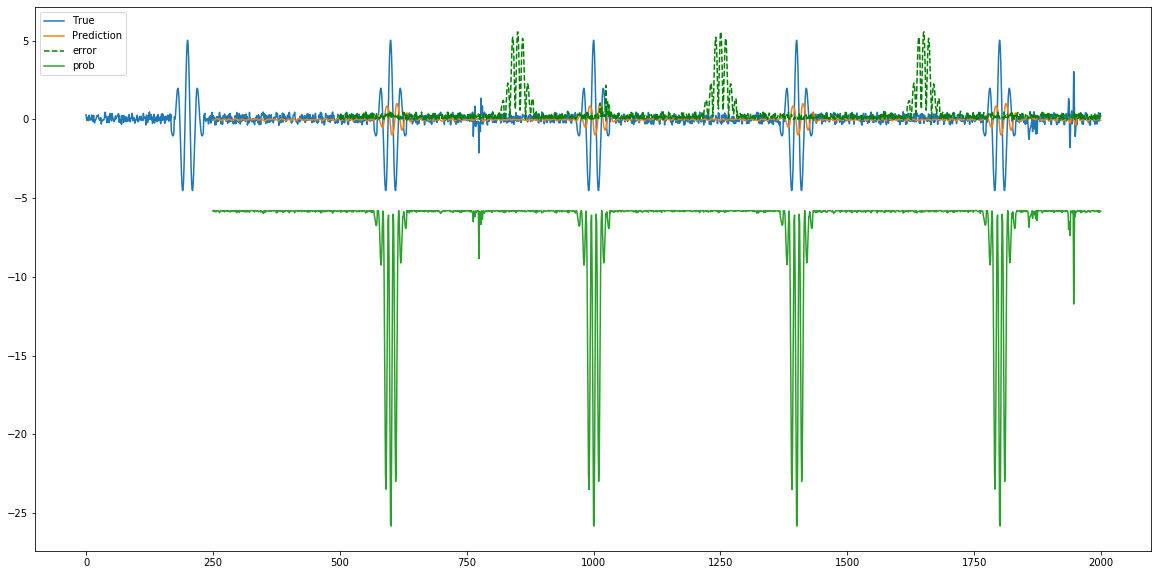

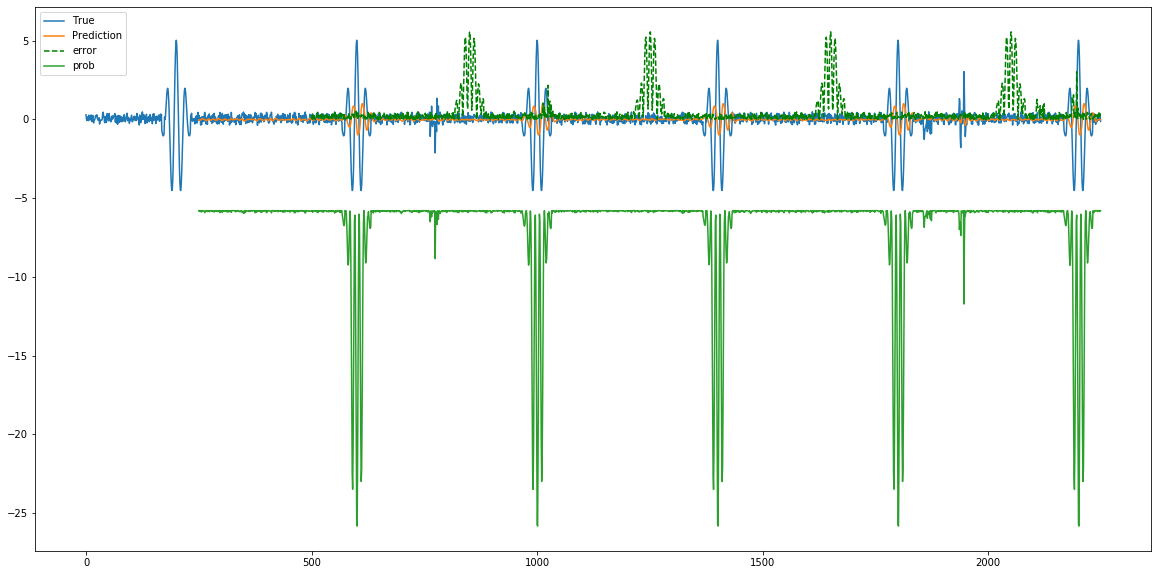

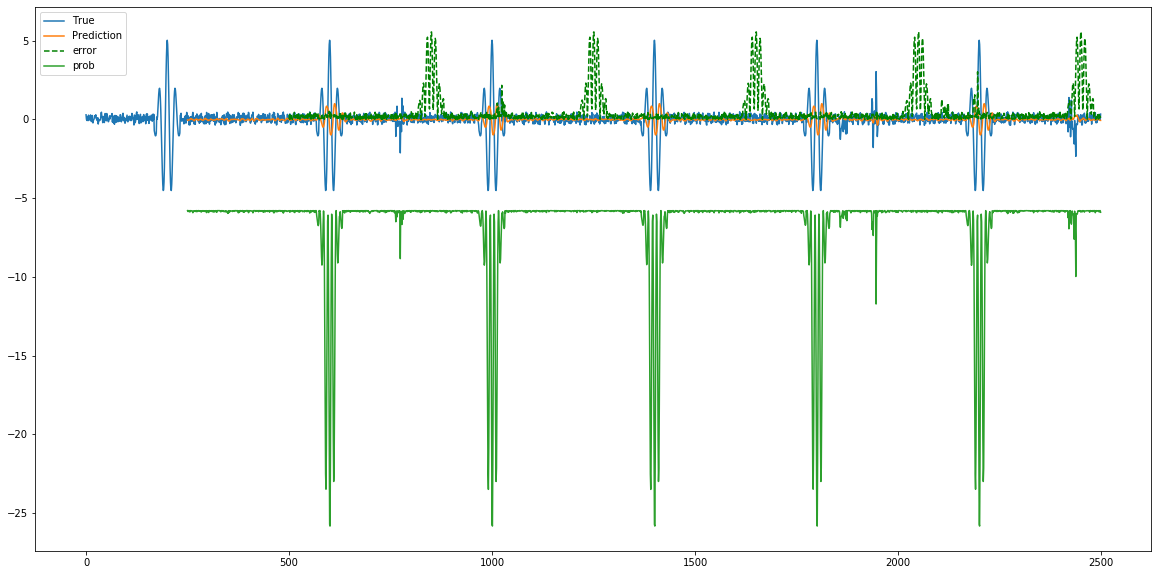

In [40]:
# the minimum number of real-time values before a prediction can be made on current model set up
# is look_back + batch_size + look_forward; after words it is minimum + (n *batch_size) for n sets
# in this case it is: 100 + 32 + 1 = 133 minimum values to create a single batch that can be used to predict one value
# in future.

# Isolate total data from raw data.npy
minimum_vals = m.look_back + m.batch_size + m.look_ahead
sets = 10
sets *= m.batch_size 
test_batch = pseudo_ccl[:minimum_vals+sets]

# Split 1D data into (3D, 2D) data via sequential_to_sequential function 
x,y = m._prepare_seq2seq_data(test_batch, look_back=m.look_back, look_ahead=m.look_ahead)
# create placeholder that consists of batch_size that will be used to predict in chunks
actual = np.zeros((m.batch_size, m.look_back, m.look_ahead))

# create placeholder variables that will store batch values of:
# predicted, error, and probability values
p = np.empty((m.batch_size, 1)); p.fill(np.nan)

error = np.zeros((m.batch_size,1)); error.fill(np.nan)
p_val = np.zeros(m.batch_size); p_val.fill(np.nan)

# set helper variables
cntr = 0
divisor = 1
s, e = 0, m.batch_size

for i in range(len(x)):
    
    # if counter reaches batch_size reset to 0
    if cntr == m.batch_size:
        cntr = 0
        
    # every batch_size perform the following:
    # populate actual placeholder with data from 'real-time'
    # use loaded model to pass actual through model.predict
    # calcualte error values between batch_sizes
    if i % m.batch_size == 0 and i != 0:
        
        #create local copy of seen data between s and e
        actual[:] = x[s:e]
        
        # perform prediction from supplied data
        p_ = m.predict(actual, batch_size=m.batch_size)
        p = np.append(p, p_)
        
        # calculate error between actual and predicted
        err = abs(actual[:,0] - p[s:e].reshape(-1,1))
        
        #append error vals to global error array that is used for plotting
        # pad left-most values with np.nan as error values are not available
        # for first batch_run
        error = np.append(error, err)
        
        # remove np.nan for local calculation of p-values
        tmp_err = error[~np.isnan(error)]
        
        # only calculate p-values if tmp_err contains values
        if len(tmp_err) > 0:
            
            # extract mean and cov of df_to_df prediction
            # has ability to choose from multiple depending
            # on what dataset has previously been used for prediction 
            p_value_set = list(m.p_values.keys())[0]
            m_ = m.p_values[p_value_set]['mean']
            cov = m.p_values[p_value_set]['cov']
            
            # calcualte p_val of tmp_err array using supplied mean, cov
            p_cal = multivariate_normal.logpdf(tmp_err, m_, cov)
            
            # pad values back with batch_size on left-most to align data
            # for plotting
            p_val = np.pad(p_cal, (m.batch_size, 0), mode='constant', constant_values=np.nan)
            
        #update helper variables
        s += m.batch_size
        e += m.batch_size

        divisor += 1
        
        # visual proof to show plot being drawn based on 'real-time' data
        # predicted data, error, p-value will come in batches.
        plt.figure(figsize=(20,10))
        plt.plot(x[:i, 0], label="True")
        plt.plot(p[:i], label="Prediction")
        plt.legend()
        plt.plot(error[:i], label='error', linestyle='--', c='g')
        plt.plot(p_val[:i]-5, label='prob')
        plt.legend()
        plt.show()
        
        
    
    # update cntr that controls when i hits batch_size
    cntr +=1
        
        


In [6]:
p = m.p_values['test_test']

In [7]:
mean_, cov_ = p['mean'], p['cov']

In [17]:
multivariate_normal.logpdf(np.asarray(0), mean_, cov_)

-0.10221373751933228